In [1]:
# %load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import InterpolationMode

from torchinfo import summary

import constants
import sys

In [3]:
# Add the root directory to the Python path
sys.path.append("/workspaces/kg-ylrust/")

In [4]:
# Import the local modules
from src.dataset import CropDataset
from src.checks import single_pass_clf
from src.helper import set_seeds

### Simple baseline model
- Resnet18
- no major data augmentations
- sigfigs
- random seeds

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Model definitions

In [6]:
weights = torchvision.models.ResNet18_Weights.DEFAULT
model_rgb = torchvision.models.resnet18(weights=weights).to(device)
auto_transforms = weights.transforms()

In [7]:
class_names = ['maize', 'rice', 'soybean', 'wheat']

Create datasets and datafolders

In [8]:
### Dataset does the following:
# Take a folder of .tif files.
# Class is defined in higher level.
# .tif files are combined into a single rgb image.
train_dataset = CropDataset(
    constants.train_dir,
    transform=auto_transforms,
    bands="rgb",
)
val_dataset = CropDataset(
    constants.validation_dir,
    transform=auto_transforms,
    bands="rgb",
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    persistent_workers=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    persistent_workers=True,
)

# Quick check
for images, labels in train_loader:
    print(images.shape)  # Should be [batch_size, 3, H, W]
    print(labels)  # Should be a list of crop types
    break

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([16, 3, 224, 224])
tensor([0, 2, 3, 0, 2, 2, 3, 0, 2, 1, 0, 2, 3, 0, 3, 2])


Transfer Learning
- Freeze intial layers

In [9]:
# Freeze earlier layers
for param in model_rgb.parameters():
    param.requires_grad = False

# Set the manual seeds
set_seeds()

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_rgb.fc = torch.nn.Linear(
    in_features=model_rgb.fc.in_features,
    out_features=output_shape,  # same number of output units as our number of classes
).to(device)

for param in model_rgb.fc.parameters():
    param.requires_grad = True

In [10]:
summary(
    model=model_rgb,
    input_size=(32, 3, 224, 224),  # make sure this is "input_size", not "input_shape"
    # col_names=["input_size"], # uncomment for smaller output
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 4]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

Check 1: Test Shapes Input & Output
- Forward pass on a single image 

Single image shape: torch.Size([3, 224, 224])

Output logits:
tensor([[0.2401, 0.1939, 0.4188, 0.2692]])

Output prediction probabilities:
tensor([[0.2392, 0.2284, 0.2861, 0.2463]])

Output prediction label:
2

Actual label:
2


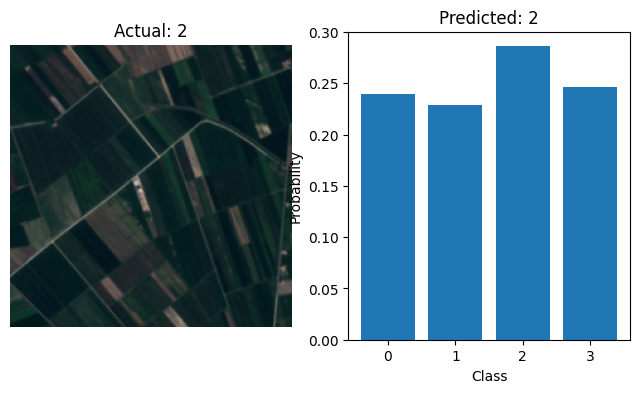

In [22]:
single_pass_clf(dataloader=train_loader, 
                model=model_rgb, 
                device=device)

Check 2: Verify Loss @ init

In [26]:
# Comparison (non-pretrained)
nonpretrained_model = torchvision.models.resnet18().to(device)
nonpretrained_model.fc = torch.nn.Linear(
    in_features=model_rgb.fc.in_features,
    out_features=output_shape,  # same number of output units as our number of classes
).to(device)

In [27]:
# Set loss
loss_fn = torch.nn.CrossEntropyLoss()

inputs, targets = next(iter(train_loader))

# Initial Loss Calculation for Non-pretrained Model
nonpretrained_model.eval()
with torch.inference_mode():
    outputs = nonpretrained_model(inputs)

# Compute initial loss
initial_loss = loss_fn(outputs, targets)
print(f'Initial Loss: {initial_loss.item()}')

# Ideal Loss Calculation
## Cross-Entropy & Binary Cross-Entropy
n_classes = 4
ideal_loss = -torch.log(torch.tensor(1.0 / n_classes))
print(f'Ideal Initial Loss: {ideal_loss.item()}')


Initial Loss: 1.8011523485183716
Ideal Initial Loss: 1.3862943649291992


In [23]:
# Set loss
loss_fn = torch.nn.CrossEntropyLoss()

inputs, targets = next(iter(train_loader))

# Initial Loss Calculation for Non-pretrained Model
model_rgb.eval()
with torch.inference_mode():
    outputs = model_rgb(inputs)

# Compute initial loss
initial_loss = loss_fn(outputs, targets)
print(f'Initial Loss: {initial_loss.item()}')

# Ideal Loss Calculation
## Cross-Entropy & Binary Cross-Entropy
n_classes = 4
ideal_loss = -torch.log(torch.tensor(1.0 / n_classes))
print(f'Ideal Initial Loss: {ideal_loss.item()}')


Initial Loss with Non-pre-trained Weights: 1.517303705215454
Ideal Initial Loss: 1.3862943649291992


Pretty close. When I didn't change the head (resnet18 default) the loss was much bigger. I think this is pretty close to say that this test passes :)
***

Check 3: Initialize final layer weights correctly

In [ ]:

- [ ] Generate a human baseline
	- [ ] Annotate 2x (consistency?)
		- 1️⃣ (ground truth) v. 2️⃣ (prediction)

- [ ] Generate an input-independent baseline
	- [ ] Compare to initial simple model

- [ ] Overfit one batch
	- [ ] loss = 0?
	- [ ] predictions = perfect?

- [ ] Go through training cycle (5-10 epochs)
	- [ ] Training loss ⤵?

- [ ] Visualize [images + labels] going into network

- [ ] Create fixed test batch -> visualize predictions every X epochs

- [ ] Gradient check!

In [ ]:
TODO: 
- add save_model function
- add naming parameters

# 8. Create a new loss and optimizer for every model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# 9. Train target model with target dataloaders and track experiments
train(model=model_rgb,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=epochs,
        device=device,
        writer=create_writer(experiment_name='RGB',
                            model_name='Resnet18-ImageNet',
                            extra=f"{epochs}_epochs"))

# 10. Save the model to file so we can get back the best model
save_filepath = f"{model_name}_{dataloader_name}_{epochs}_epochs.pth"
save_model(model=model_rgb,
            target_dir="models",
            model_name=save_filepath)

1) Build base

2) Build EarlyStopper

3) Build StatifiedKFold